In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm 
import seaborn as sns
from patsy import dmatrix

In [30]:
# Load the combined data
combined_data = pd.read_csv("Combined Data.csv")

# Convert the 'Date' column to datetime format
combined_data['Date'] = pd.to_datetime(combined_data['Date'], errors='coerce')
combined_data['Total_nonfarm'] = pd.to_numeric(combined_data['Total_nonfarm'], errors='coerce')
combined_data['Total_private'] = pd.to_numeric(combined_data['Total_private'], errors='coerce')

# Set the 'Date' column as the index
combined_data.set_index('Date', inplace=True)

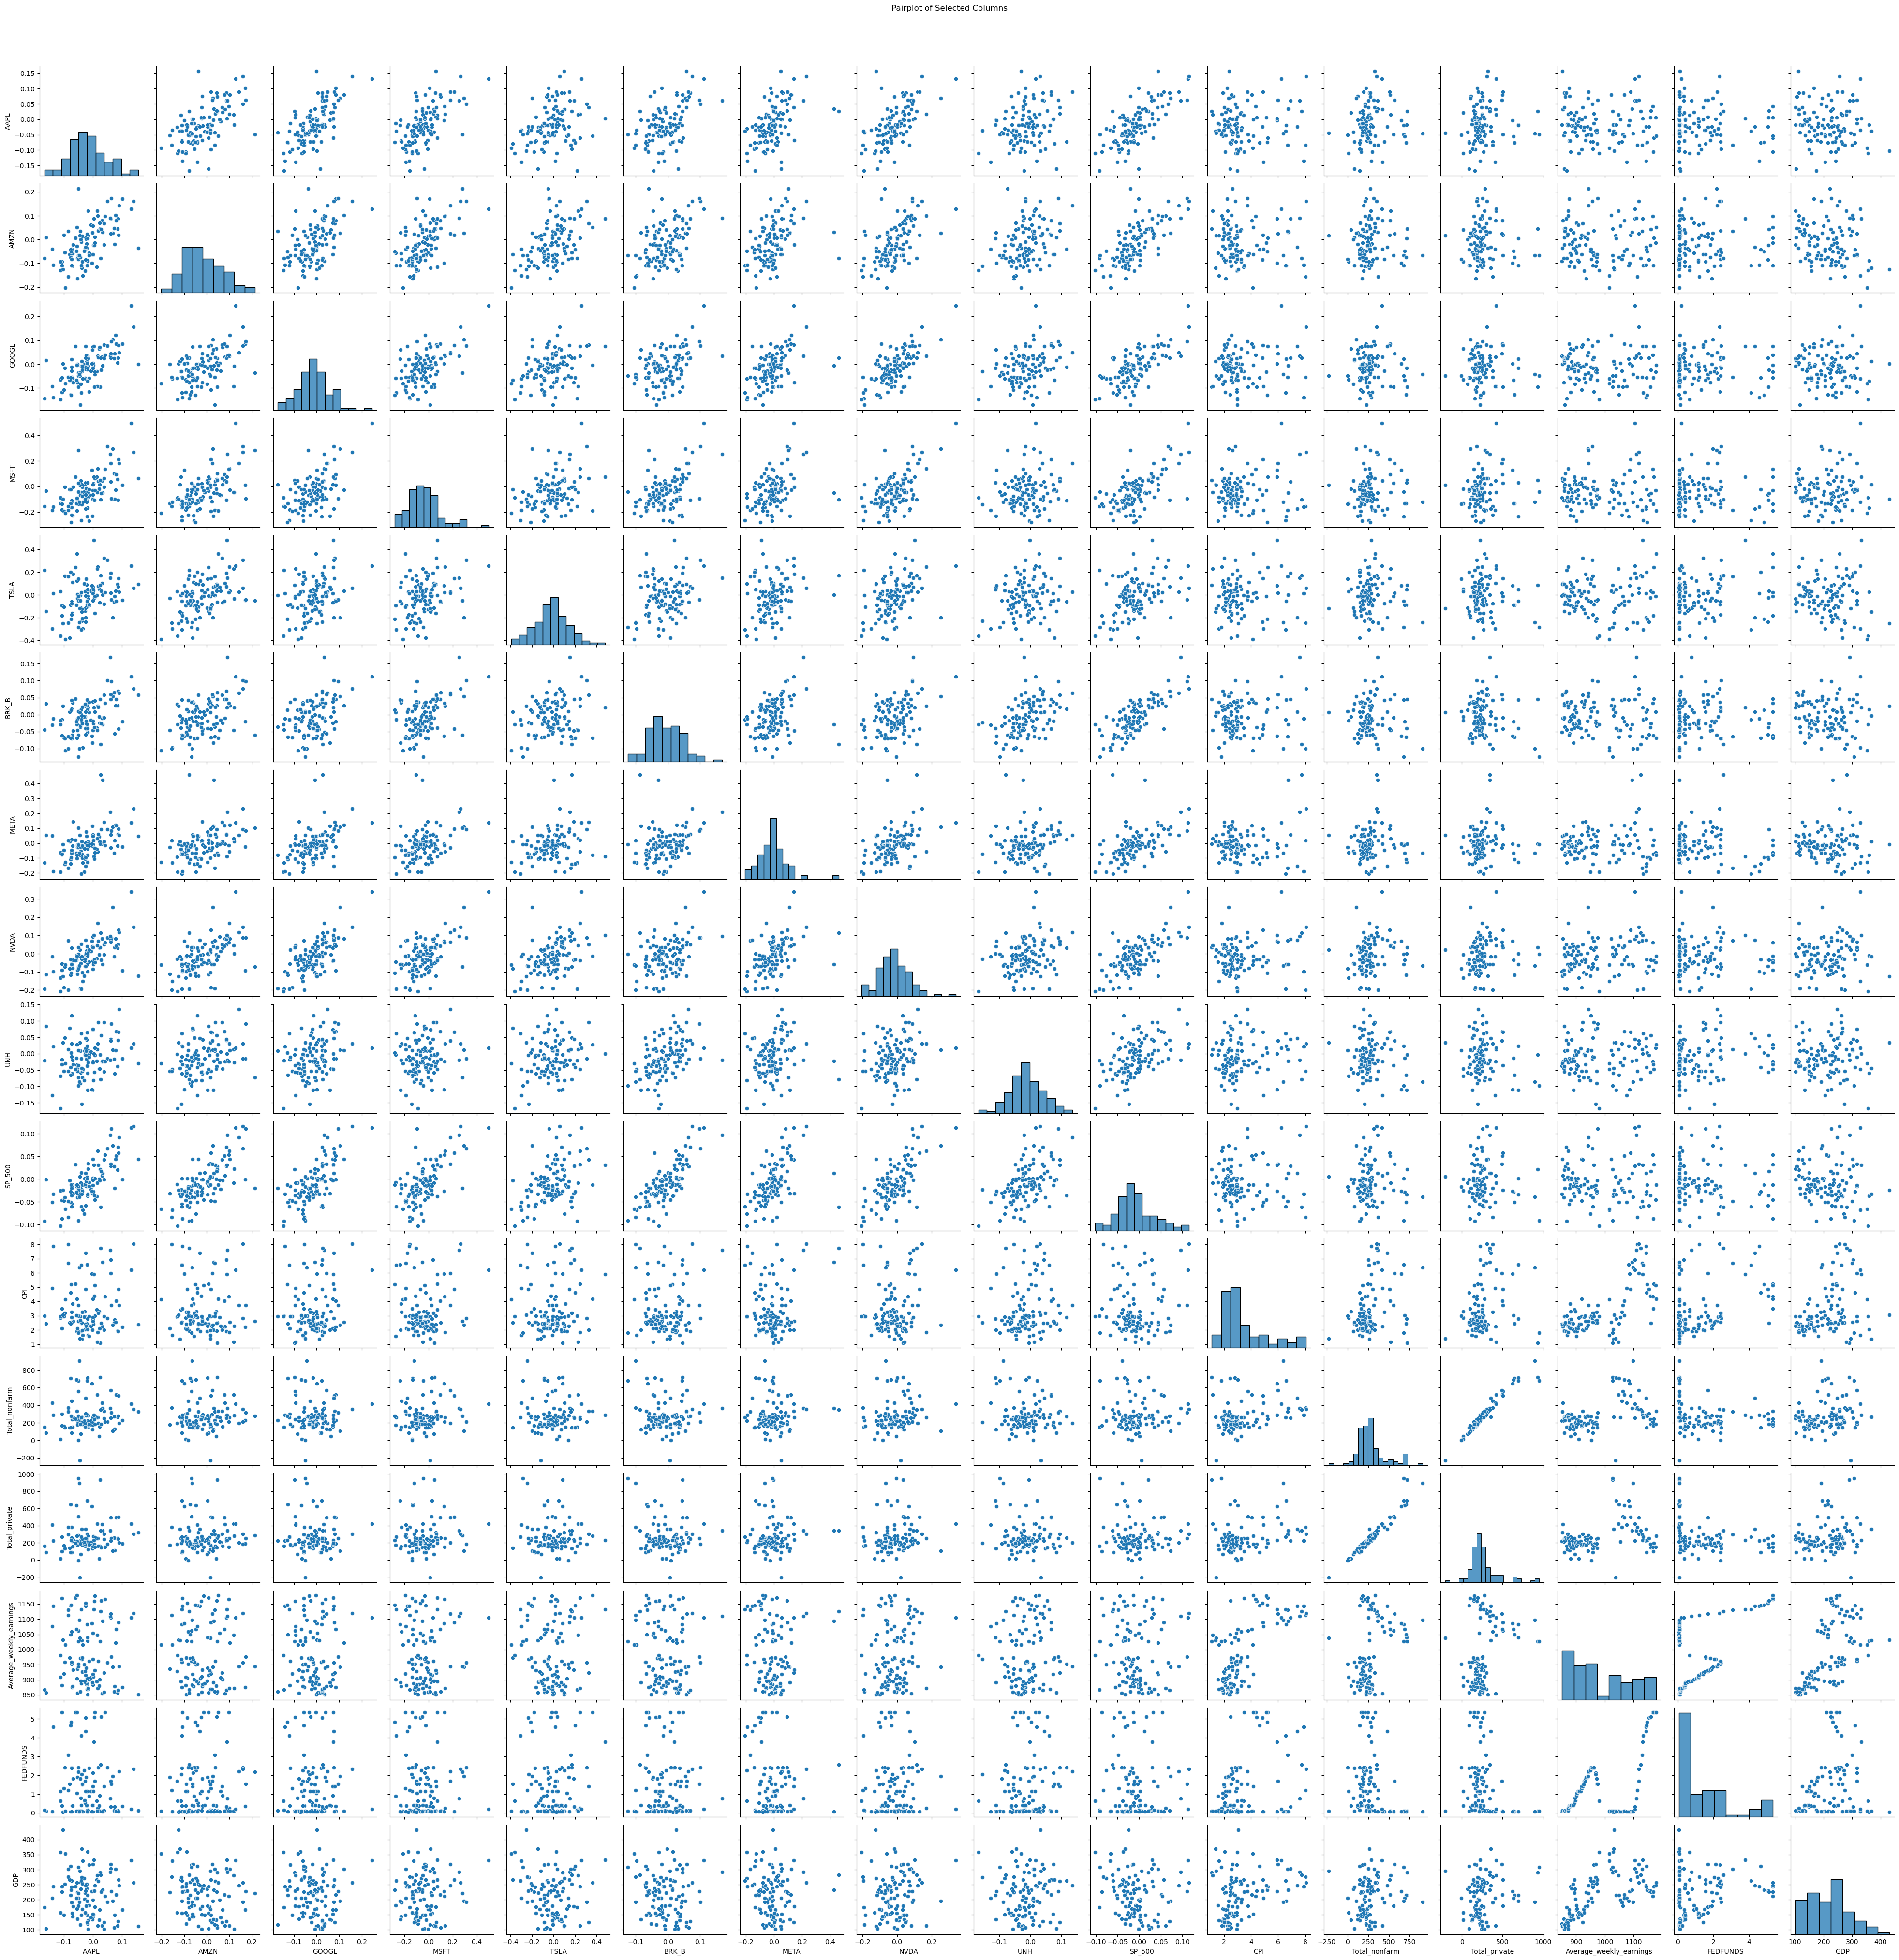

In [36]:
# Create a pairplot
sns.pairplot(combined_data)
plt.suptitle('Pairplot of Selected Columns', y=1.02)
plt.show()

In [32]:
independent_vars = [col for col in combined_data.columns if col != 'SP_500']
formula = 'SP_500 ~ ' + ' + '.join(independent_vars)

model = ols(formula, data=combined_data).fit()

print(model.summary())

print(anova_lm(model))

                            OLS Regression Results                            
Dep. Variable:                 SP_500   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     37.11
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           9.21e-32
Time:                        18:57:19   Log-Likelihood:                 281.56
No. Observations:                 105   AIC:                            -531.1
Df Residuals:                      89   BIC:                            -488.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Multiple of the above variables have a very high p-value. I will remove variables one by one until I get all significant variables.

In [33]:
while True:
    p_values = model.pvalues.drop('Intercept')
    max_p_value = p_values.max()
    if max_p_value > 0.05:
        worst_feature = p_values.idxmax()
        independent_vars.remove(worst_feature)
        formula = 'SP_500 ~ ' + ' + '.join(independent_vars)
        model = ols(formula, data=combined_data).fit()
    else:
        break

print(model.summary())

print(anova_lm(model))

                            OLS Regression Results                            
Dep. Variable:                 SP_500   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     121.0
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           6.25e-42
Time:                        18:57:24   Log-Likelihood:                 291.56
No. Observations:                 111   AIC:                            -571.1
Df Residuals:                     105   BIC:                            -554.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0027      0.002      1.508      0.1

Removing all p-values above 0.05 itereatively results in the above regression with only AAPL, AMZN, GOOGL, BRK_B, and UNH. This means that all of the other variables were not significant and should not be in the regression.

The Multiple Linear Regression result from these changes results in the formula:

$$\hat{y} = 0.0027 + 0.1055 \cdot \text{AAPL} + 0.1226 \cdot \text{AMZN} + 0.1724 \cdot \text{GOOGL} + 0.4096 \cdot \text{BRK B} + 0.0859 \cdot \text{UNH}$$

For every 1 unit increase in AAPL stock return, the S&P 500 value is expected to increase by 0.1055.

For every 1 unit increase in AMZN stock return, the S&P 500 value is expected to increase by 0.1226.

For every 1 unit increase in GOOGL stock return, the S&P 500 value is expected to increase by 0.1724.

For every 1 unit increase in BRK B stock return, the S&P 500 value is expected to increase by 0.4096.

For every 1 unit increase in UNH stock return, the S&P 500 value is expected to increase by 0.0859.

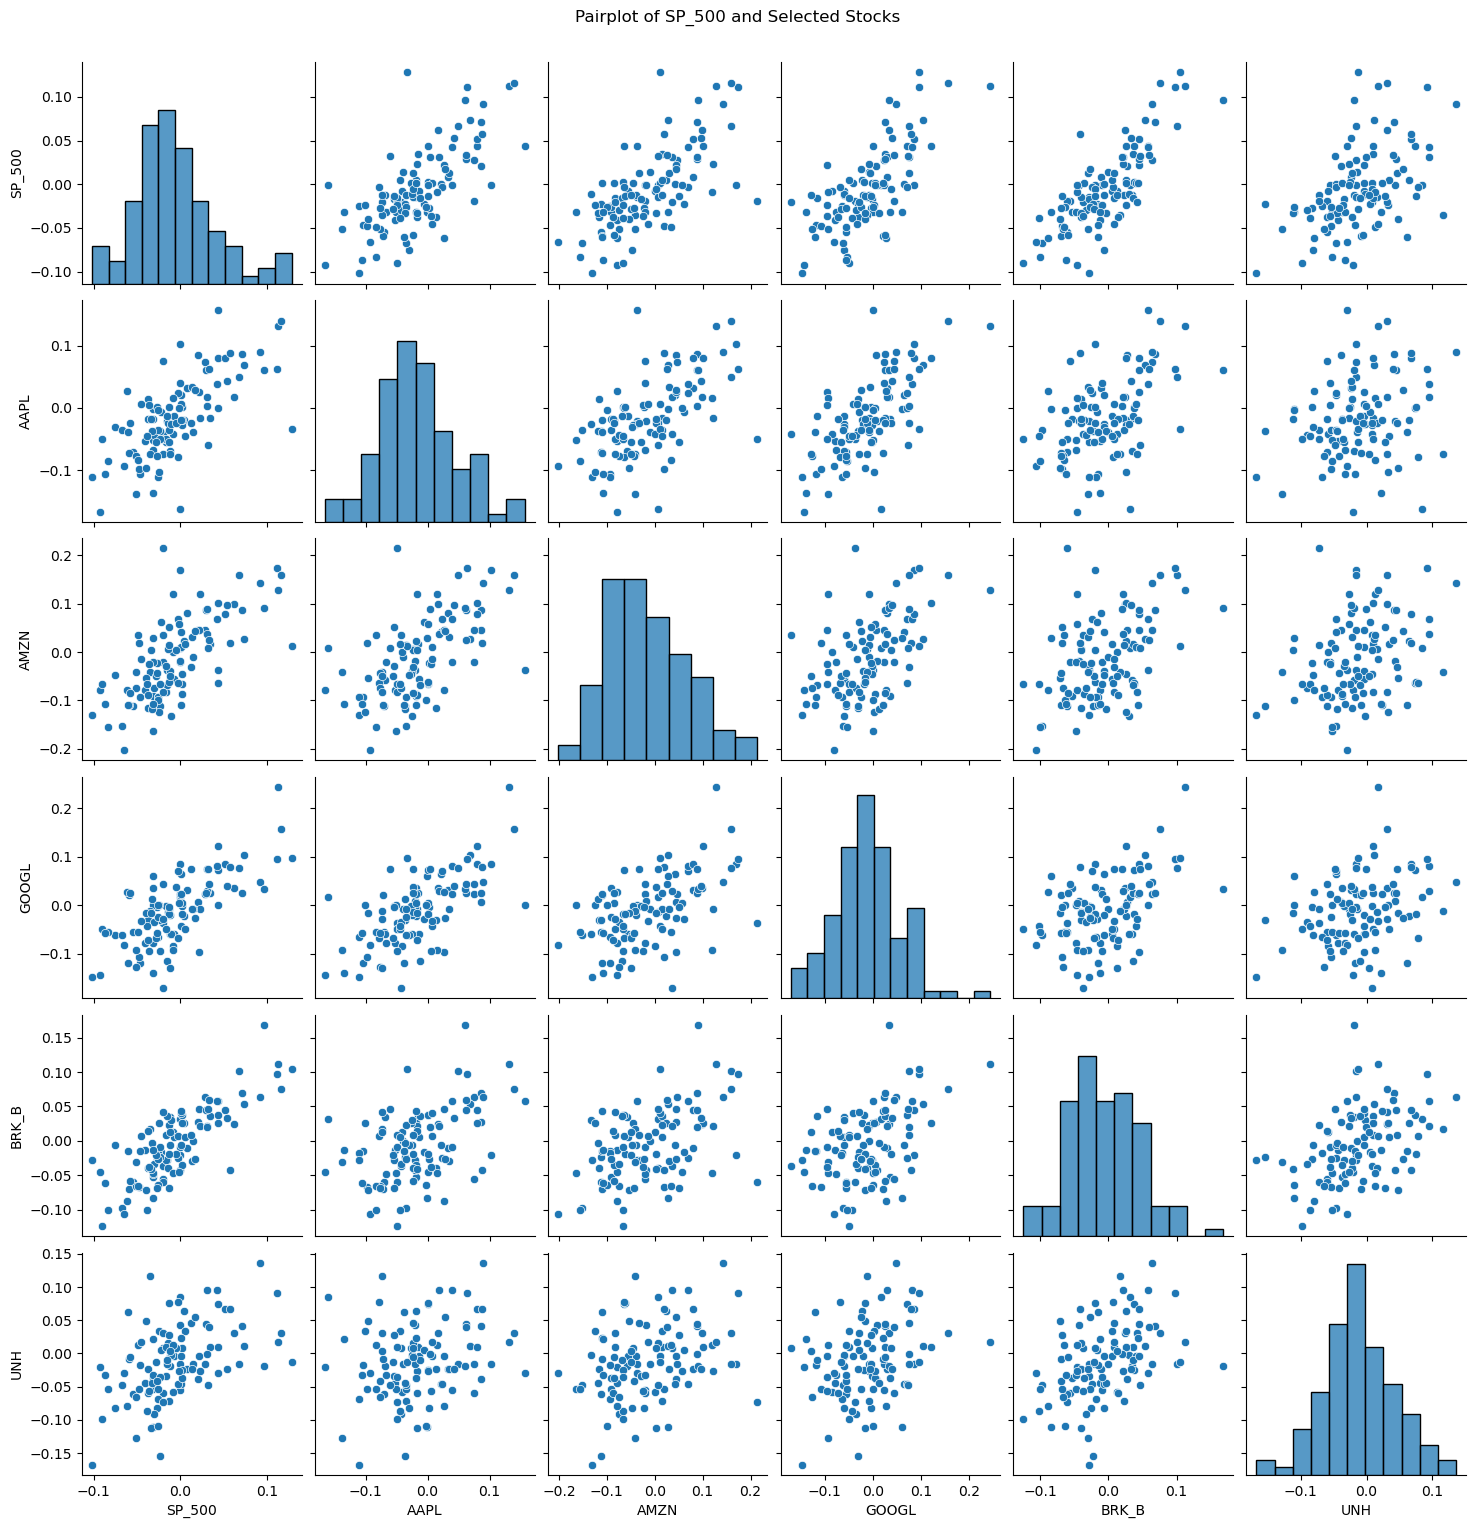

In [21]:
sns.pairplot(combined_data[['SP_500', 'AAPL', 'AMZN', 'GOOGL', 'BRK_B', 'UNH']])
plt.suptitle('Pairplot of SP_500 and Selected Stocks', y=1.02)
plt.show()

As seen in the above pairplot of the kept stocks, there is a linear relationship between all of the variables. As expected, the BRK_B stock has the closest relationship with S&P 500 because the $\beta$ value for BRK_B was the highest among all of the values at $0.4096$

Outlier: 2020-02-01 00:00:00


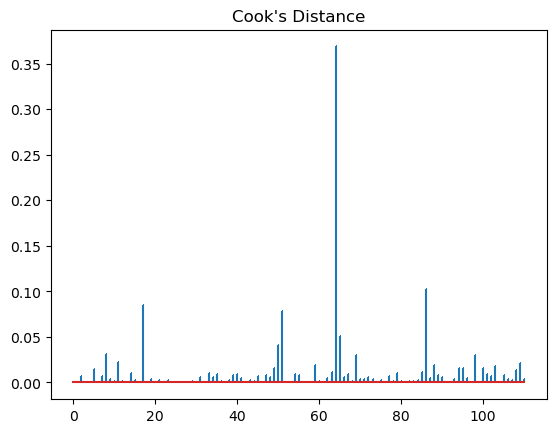

In [34]:
# Cook's Distance
influence = model.get_influence()
(c, p) = influence.cooks_distance
for i in range(len(c)):
    if c[i] > 0.15:
        print(f"Outlier: {combined_data.index[i]}")
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.title("Cook's Distance")
plt.show()

As seen above in the Cook's Distance graph, the value at 2020-02-01 is considerably larger than the other values, so it is an influential point. This can be explained by the drastic drop in stock market at the beginning of the COVID-19 pandemic. I will remove this point and re-generate the model

In [35]:
# Remove the row with date 2020-02-01
combined_data = combined_data.drop(pd.to_datetime('2020-02-01'))


independent_vars = [col for col in combined_data.columns if col != 'SP_500']
formula = 'SP_500 ~ ' + ' + '.join(independent_vars)

model = ols(formula, data=combined_data).fit()

while True:
    p_values = model.pvalues.drop('Intercept')
    max_p_value = p_values.max()
    if max_p_value > 0.05:
        worst_feature = p_values.idxmax()
        independent_vars.remove(worst_feature)
        formula = 'SP_500 ~ ' + ' + '.join(independent_vars)
        model = ols(formula, data=combined_data).fit()
    else:
        break

print(model.summary())

print(anova_lm(model))

                            OLS Regression Results                            
Dep. Variable:                 SP_500   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     121.3
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           2.24e-44
Time:                        18:57:38   Log-Likelihood:                 302.69
No. Observations:                 110   AIC:                            -591.4
Df Residuals:                     103   BIC:                            -572.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0023      0.002      1.415      0.1

With this outlier removed, the variables that should be kept in the model have changed and we now have more influential variables! The new values are AAPL, AMZN, GOOGL, BRK_B, NVDA, and UNH.

The new formula for the regression is: 

$$\hat{y} = 0.0023 + 0.1192 \cdot \text{AAPL} + 0.1094 \cdot \text{AMZN} + 0.1015 \cdot \text{GOOGL} + 0.3650 \cdot \text{BRK B} + 0.0743 \cdot \text{NVDA} + 0.0859 \cdot \text{UNH}$$

In [37]:
# calculate the sum of (y_i - y_hat_i)^2
y_hat = model.predict()
y = combined_data['SP_500']
residuals = y - y_hat
SSE = (residuals**2).sum()
print(SSE)

0.02622774993743477


The PRESS (Predicted Error Sum of Squares) statistic of 0.026 is low, meaning that the model will perform well. This also matches the F-statistic p-value of $2.24 \times 10^{-44}$ which is extremely small.

The $R^2_{Adj}$ value is 0.869 which means that the model explains 86.9% of the variability. This indicates a strong relationship between the predictors and the S&P 500 value.